# this kernel is from https://www.kaggle.com/fabiendaniel/elo-world

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

/Users/gjwei/Desktop/competition/LightGBM/python-package/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# 1. load dataset`

In [2]:
new_transcations = pd.read_csv('../input/new_merchant_transactions.csv', parse_dates=['purchase_date'])

In [3]:
historical_transactions = pd.read_csv("../input/historical_transactions.csv", parse_dates=['purchase_date'])

In [4]:
def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transcations)

In [5]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [6]:
new_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_415bb3a509,107,0,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,1,C_ID_415bb3a509,140,0,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,1,C_ID_415bb3a509,330,0,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,1,C_ID_415bb3a509,-1,1,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,1,C_ID_ef55cf8d4b,-1,1,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [7]:
# read train and test dataset
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df
#_________________________________________
train = read_data('../input/train.csv')
test = read_data('../input/test.csv')

target = train['target']
del train['target']

In [20]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# feature engineering

In [11]:
historical_transactions['month_diff'] = ((datetime.datetime.today() - historical_transactions['purchase_date']).dt.days) // 30

historical_transactions['month_diff'] += historical_transactions['month_lag']

In [12]:
new_transactions['month_diff'] = ((datetime.datetime.today() - new_transactions['purchase_date']).dt.days) // 30

new_transactions['month_diff'] += new_transactions['month_lag']

In [18]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

In [21]:
historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

Mem. usage decreased to 1332.66 Mb (57.1% reduction)
Mem. usage decreased to 86.12 Mb (58.9% reduction)


In [23]:
agg_fun = {'authorized_flag': ['mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

In [25]:
authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

In [28]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

In [29]:
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
    'category_1': ['sum', 'mean'],
    'category_2_1.0': ['mean'],
    'category_2_2.0': ['mean'],
    'category_2_3.0': ['mean'],
    'category_2_4.0': ['mean'],
    'category_2_5.0': ['mean'],
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'month_diff': ['mean']
    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [30]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

,card_id,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_diff_mean
0,C_ID_00007093c1,35,4.0,0.114286,0.000000,0.000000,0.885714,0.0,0.000000,0.000000,0.828571,0.171429,11,8,2,3,7,-14.401965,-0.411485,1.507069,-0.728876,0.430059,45,1.285714,3,1,0.667367,5.914286,12,1,3.071419,28858113.0,1.489250e+09,1.518108e+09,-6.028571,0,-11,3.535415,9.857143
1,C_ID_0001238066,3,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.666667,0.000000,1.000000,0.000000,2,1,2,2,1,-1.789928,-0.596643,-0.596643,-0.596643,0.000000,3,1.000000,1,1,0.000000,8.666667,12,2,5.773503,3609150.0,1.514660e+09,1.518269e+09,-1.333333,0,-2,1.154701,9.333333
2,C_ID_0001506ef0,4,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.750000,0.250000,0.000000,4,4,1,1,4,-2.905782,-0.726445,-0.708590,-0.740491,0.016203,1,0.250000,1,0,0.500000,5.500000,12,2,4.725816,22098875.0,1.496772e+09,1.518871e+09,-2.500000,0,-8,3.785939,10.000000
3,C_ID_0001793786,27,2.0,0.074074,0.111111,0.296296,0.111111,0.0,0.000000,0.814815,0.185185,0.000000,17,14,4,8,11,-11.825338,-0.437975,1.236592,-0.745405,0.498150,5,0.185185,1,0,0.395847,6.481481,9,3,2.375684,16780236.0,1.488636e+09,1.505416e+09,-3.518519,-1,-7,2.375684,13.888889
4,C_ID_000183fdda,7,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.428571,0.571429,4,4,1,1,4,-0.941381,-0.134483,0.334099,-0.714541,0.452741,19,2.714286,6,1,2.288689,8.285714,10,8,0.755929,6701589.0,1.502099e+09,1.508801e+09,-5.714286,-4,-6,0.755929,9.571429


In [31]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]

,card_id,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,auth_category_3_B_mean,auth_category_3_C_mean,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean
0,C_ID_00007093c1,114,24.0,0.210526,0.000000,0.000000,0.780702,0.0,0.008772,0.0,0.842105,0.157895,28,18,3,4,13,-62.443077,-0.547746,1.206539,-0.728876,0.237426,147,1.289474,6,1,0.795159,6.517544,12,1,3.371490,32627654.0,1.487081e+09,1.519708e+09,-5.798246,0,-12,3.441495,9.833333
1,C_ID_0001238066,120,2.0,0.016667,0.783333,0.000000,0.000000,0.0,0.150000,0.0,0.708333,0.266667,65,29,6,18,17,-70.657272,-0.588811,0.768095,-0.734887,0.192614,195,1.625000,10,-1,1.501050,7.275000,12,1,4.895483,13110825.0,1.506638e+09,1.519748e+09,-1.825000,0,-5,1.294218,9.866667
2,C_ID_0001506ef0,62,0.0,0.000000,0.032258,0.000000,0.967742,0.0,0.000000,1.0,0.000000,0.000000,28,19,2,3,12,-31.696098,-0.511227,1.493545,-0.740491,0.484575,0,0.000000,0,0,0.000000,6.887097,12,1,4.538017,34460275.0,1.484411e+09,1.518871e+09,-4.983871,0,-13,4.248402,9.951613
3,C_ID_0001793786,189,0.0,0.000000,0.042328,0.359788,0.063492,0.0,0.000000,1.0,0.000000,0.000000,114,45,4,9,22,-24.960674,-0.132067,4.554145,-0.737892,0.867916,0,0.000000,0,0,0.000000,6.698413,10,1,2.301491,24487497.0,1.484994e+09,1.509481e+09,-3.301587,0,-9,2.301491,13.878307
4,C_ID_000183fdda,137,4.0,0.029197,0.051095,0.007299,0.905109,0.0,0.007299,0.0,0.729927,0.240876,71,34,7,9,20,-67.896553,-0.495595,2.764788,-0.737892,0.523760,245,1.788321,10,-1,2.108912,6.810219,12,1,4.538289,15148616.0,1.504444e+09,1.519592e+09,-2.284672,0,-5,1.782055,9.817518


In [32]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean
0,C_ID_00007093c1,2,0,0.000000,0.500000,0.000000,0.50000,0.0,0.000000,0.0,1.000000,0.000000,2,2,2,2,2,-1.328125,-0.664062,-0.656738,-0.671875,0.010704,2,1.000000,1,1,0.000000,4.000000,4,4,0.000000,537024.0,1.522754e+09,1.523291e+09,2.000000,2,2,0.000000,10.000000
1,C_ID_0001238066,26,2,0.076923,0.769231,0.000000,0.00000,0.0,0.115385,0.0,0.807692,0.153846,25,15,4,8,9,-14.851562,-0.571289,-0.078308,-0.740723,0.173462,42,1.615385,10,-1,2.079941,3.346154,4,3,0.485165,5195343.0,1.519923e+09,1.525118e+09,1.346154,2,1,0.485165,9.807692
2,C_ID_0001506ef0,2,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,1.0,0.000000,0.000000,1,2,1,1,2,-1.447266,-0.723633,-0.715332,-0.731934,0.011742,0,0.000000,0,0,0.000000,3.000000,3,3,0.000000,471152.0,1.521239e+09,1.521710e+09,1.000000,1,1,0.000000,10.000000
3,C_ID_0001793786,31,0,0.000000,0.483871,0.258065,0.16129,0.0,0.032258,1.0,0.000000,0.000000,31,21,5,7,14,-0.229004,-0.007385,3.130859,-0.737793,0.947266,0,0.000000,0,0,0.000000,11.322581,12,11,0.475191,3981096.0,1.510761e+09,1.514742e+09,1.322581,2,1,0.475191,13.419355
4,C_ID_000183fdda,11,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,0.0,0.545455,0.363636,11,9,2,2,6,-6.589844,-0.599121,-0.107666,-0.732422,0.182861,16,1.454545,4,-1,1.293340,3.272727,4,3,0.467099,5106807.0,1.519994e+09,1.525100e+09,1.272727,2,1,0.467099,9.727273


In [33]:
authorized_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,month_diff,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C,purchase_month
0,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703331,1.498405e+09,16,37,10,1,0,0,0,0,1,0,0,6
1,1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.733128,1.500121e+09,16,16,10,1,0,0,0,0,1,0,0,7
2,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720386,1.502316e+09,16,37,10,1,0,0,0,0,1,0,0,8
3,1,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,1.504347e+09,16,34,10,1,0,0,0,0,1,0,0,9
4,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,-0.722865,1.489108e+09,16,37,10,1,0,0,0,0,1,0,0,3


In [34]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])
    
    agg_func = {
        'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
        'installments': ['count', 'sum', 'mean', 'min', 'max', 'std']
    }
    
    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)
    
    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

final_group = aggregate_per_month(authorized_transactions)

In [35]:
final_group.head()

,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-6.000000,3.894440,8.769231,3.539158,-4.803313,2.175011,-0.536131,0.075418,-0.702649,0.041293,-0.126683,0.446167,0.197339,0.120199,8.769231,3.539158,11.307692,4.210792,1.369646,0.423190,1.000000,0.000000,2.538462,1.613246,0.625428,0.675607
1,C_ID_0001238066,-2.500000,1.870829,20.000000,11.696153,-11.776212,6.676914,-0.603215,0.046045,-0.730351,0.002699,-0.160977,0.485869,0.151393,0.093832,20.000000,11.696153,32.500000,24.501020,1.652873,0.410539,0.666667,0.816497,4.666667,2.875181,1.256525,0.521292
2,C_ID_0001506ef0,-6.230769,4.225988,4.769231,4.342692,-2.438161,2.902502,-0.446660,0.271125,-0.725724,0.011212,0.161333,0.748701,0.496308,0.415117,4.769231,4.342692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,C_ID_0001793786,-4.500000,3.027650,18.900000,12.160501,-2.496067,4.018810,-0.005687,0.271221,-0.646277,0.166230,2.190924,1.290775,0.880276,0.259048,18.900000,12.160501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,C_ID_000183fdda,-2.500000,1.870829,22.833333,7.167054,-11.316092,4.800612,-0.489227,0.141015,-0.728405,0.009876,1.151797,1.062785,0.472149,0.315407,22.833333,7.167054,40.833333,14.048725,1.834943,0.362557,0.333333,1.032796,9.166667,2.041241,2.144389,0.665529


In [38]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    
    u.columns = [field1 + "_" + field2 + "_" + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u


In [42]:
additional_fields = successive_aggregates(new_transactions, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'installments', 'purchase_amount'),
                                          on='card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'city_id', 'purchase_amount'),
                                           on='card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'category_1', 'installments'),
                                           on='card_id', how='left')

In [43]:
additional_fields.head()

,card_id,category_1_purchase_amount_mean,category_1_purchase_amount_min,category_1_purchase_amount_max,category_1_purchase_amount_std,installments_purchase_amount_mean,installments_purchase_amount_min,installments_purchase_amount_max,installments_purchase_amount_std,city_id_purchase_amount_mean,city_id_purchase_amount_min,city_id_purchase_amount_max,city_id_purchase_amount_std,category_1_installments_mean,category_1_installments_min,category_1_installments_max,category_1_installments_std
0,C_ID_00007093c1,-0.664062,-0.664062,-0.664062,NaN,-0.664062,-0.664062,-0.664062,NaN,-0.664062,-0.671875,-0.656738,0.010704,1.000000,1.000000,1.000000,NaN
1,C_ID_0001238066,-0.607422,-0.650391,-0.564453,0.06076,-0.423828,-0.625977,-0.151978,0.222046,-0.558105,-0.666992,-0.472168,0.072632,2.479167,1.458333,3.500000,1.443676
2,C_ID_0001506ef0,-0.723633,-0.723633,-0.723633,NaN,-0.723633,-0.723633,-0.723633,NaN,-0.723633,-0.723633,-0.723633,NaN,0.000000,0.000000,0.000000,NaN
3,C_ID_0001793786,-0.007385,-0.007385,-0.007385,NaN,-0.007385,-0.007385,-0.007385,NaN,-0.247070,-0.572754,0.249268,0.346924,0.000000,0.000000,0.000000,NaN
4,C_ID_000183fdda,-0.599121,-0.599121,-0.599121,NaN,-0.491211,-0.696289,-0.107666,0.233887,-0.572266,-0.604980,-0.539062,0.046600,1.454545,1.454545,1.454545,NaN


**目前得到了history, authorized, new, final_group, auth_mean, additional_fields**四个特征文件

In [45]:
def merge_features(data_df, features_dfs):
    for features_df in features_dfs:
        data_df = pd.merge(data_df, features_df, on='card_id', how='left')
    
    return data_df

In [46]:
feature_dfs = [history, authorized, new, final_group, auth_mean, additional_fields]
train = merge_features(train, feature_dfs)
test = merge_features(test, feature_dfs)

In [54]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_diff_mean,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,auth_category_3_B_mean,auth_category_3_C_mean,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std,authorized_flag_mean,category_1_purchase_amount_mean,category_1_purchase_amount_min,category_1_purchase_amount_max,category_1_purchase_amount_std,installments_purchase_amount_mean,installments_purchase_amount_min,installments_purchase_amount_max,installments_purchase_amount_std,city_id_purchase_amount_mean,city_id_purchase_amount_min,city_id_purchase_amount_max,city_id_purchase_amount_std,category_1_installments_mean,category_1_installments_min,category_1_installments_max,category_1_installments_std
0,2017-06-01,C_ID_92a2005557,5,2,1,245,13.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.692308,0.307692,0.000000,12.0,10.0,1.0,2.0,7.0,-8.571723,-0.659363,-0.431922,-0.737892,0.098851,4.0,0.307692,1.0,0.0,0.48

In [49]:
del feature_dfs, history, authorized, new, final_group, auth_mean, additional_fields
import gc; gc.collect()

9573

In [53]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = ['feature_2', 'feature_3']


# train models

In [52]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}



In [55]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


/Users/gjwei/Desktop/competition/LightGBM/python-package/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/gjwei/Desktop/competition/LightGBM/python-package/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.71437	valid_1's rmse: 3.7766
[200]	training's rmse: 3.6457	valid_1's rmse: 3.72897
[300]	training's rmse: 3.60206	valid_1's rmse: 3.70579
[400]	training's rmse: 3.57125	valid_1's rmse: 3.69383
[500]	training's rmse: 3.54792	valid_1's rmse: 3.68675
[600]	training's rmse: 3.52881	valid_1's rmse: 3.68176
[700]	training's rmse: 3.51305	valid_1's rmse: 3.67851
[800]	training's rmse: 3.49869	valid_1's rmse: 3.67676
[900]	training's rmse: 3.4857	valid_1's rmse: 3.67537
[1000]	training's rmse: 3.4732	valid_1's rmse: 3.67453
[1100]	training's rmse: 3.46187	valid_1's rmse: 3.6738
[1200]	training's rmse: 3.451	valid_1's rmse: 3.67331
[1300]	training's rmse: 3.44015	valid_1's rmse: 3.67295
[1400]	training's rmse: 3.42934	valid_1's rmse: 3.67271
[1500]	training's rmse: 3.41856	valid_1's rmse: 3.67263
[1600]	training's rmse: 3.40875	valid_1's rmse: 3.67267
[1700]	training's rmse: 3.39861	valid_1's rmse: 3.67258
E

# feature_importance

In [56]:
feature_importance_df.head()

,feature,importance,fold
0,feature_1,505,1
1,feature_2,414,1
2,feature_3,186,1
3,elapsed_time,1331,1
4,hist_transactions_count,1184,1


In [64]:
cols = (feature_importance_df[['feature', 'importance']]
       .groupby('feature')
       .mean()
       .sort_values(by='importance', ascending=False))

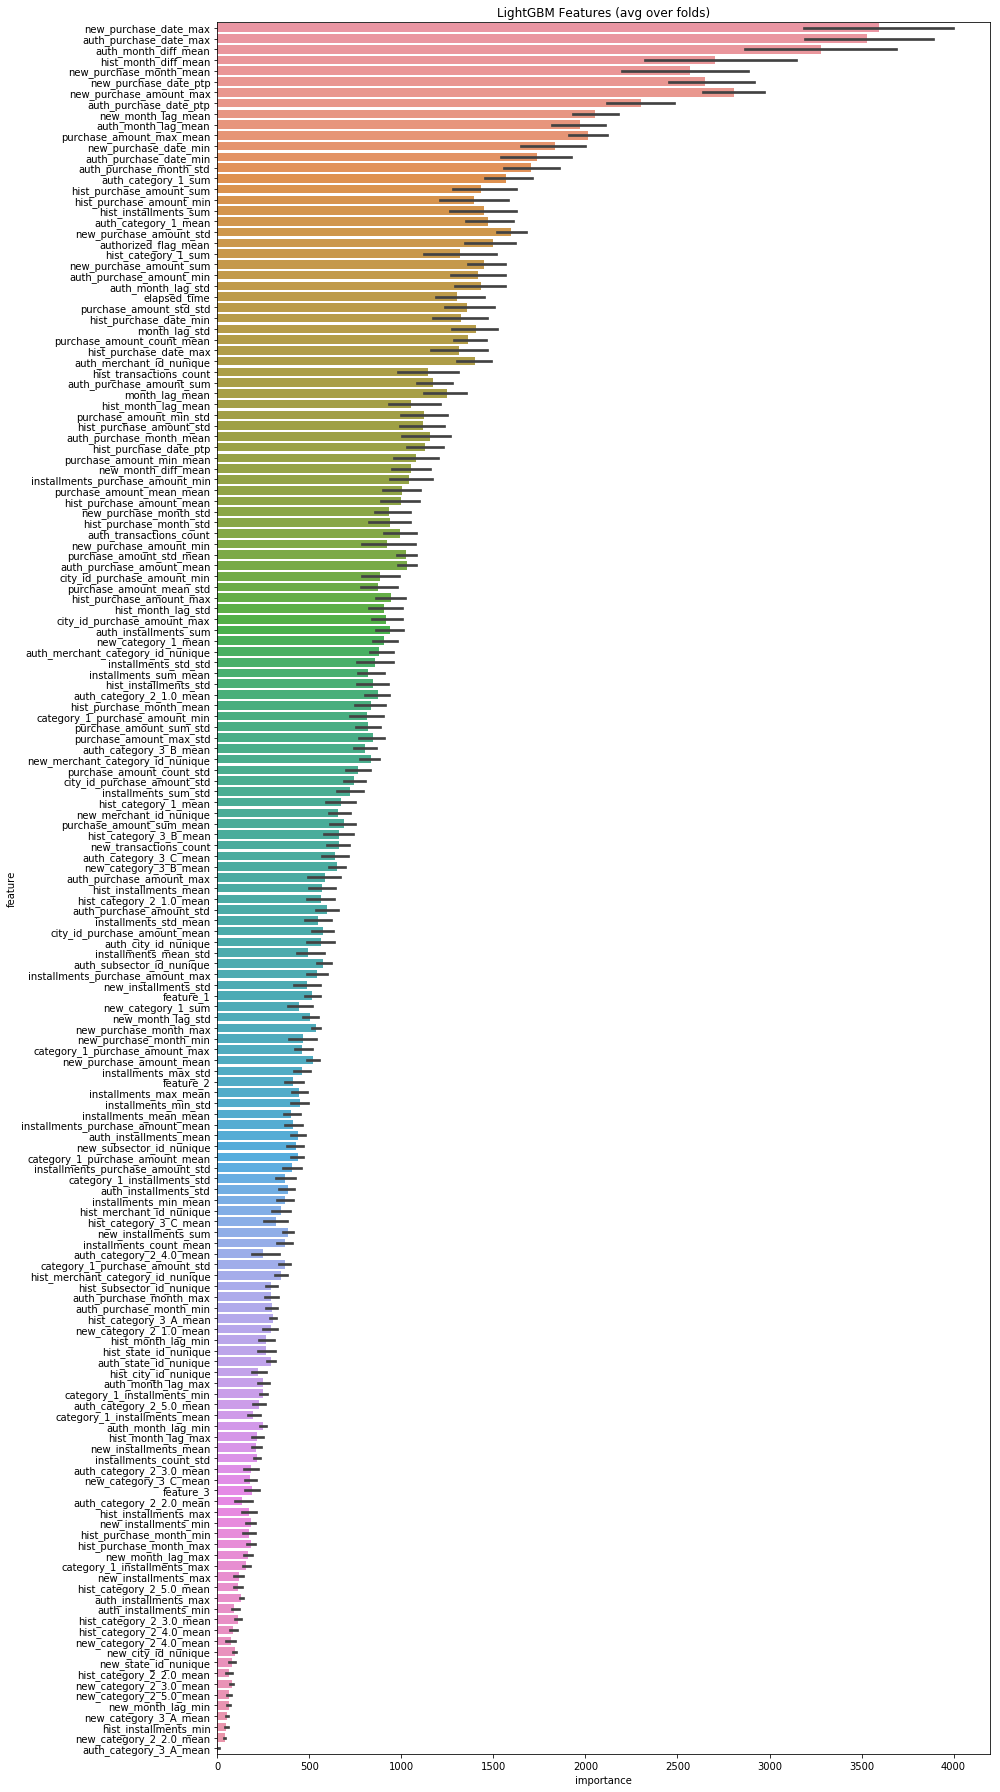

In [61]:
cols = (feature_importance_df[['feature', 'importance']]
       .groupby('feature')
       .mean()
       .sort_values(by='importance', ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [62]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)